# Testing TensorFlow algorithms for linear regression
We would like to estimate the Vs log based on the other logs we have present.

This notebook basically follows the https://www.tensorflow.org/tutorials/keras/regression tutorial.
## Prerequisites 
Import necessary python libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

c:\program files\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python37\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\program files\python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


2.3.1


Create a project, with wells and logs defined by the *project_table.xlsx* excel sheet.
And load the selected data as a Panda DataFrame.

**Note 1** Only the logs that are present in all selected wells are included in the DataFrame.

**Note 2** The *well_keys* maps the floating number in the *Well* column of the DataFrame to well names

In [2]:
from core.well import Project
wp = Project(
    name='MyProject',  
    project_table='excels/project_table.xlsx'
)
raw_dataset, well_keys = wp.data_frame()
raw_dataset.tail()

0 WELL_A test_data/Well A.las
1 WELL_B test_data/Well B.las
2 WELL_C test_data/Well C.las


,vp_dry,vcl,phie,depth,vs_dry,rho_dry,Well
45179,NaN,NaN,NaN,2122.4624,NaN,2.3882,2.0
45180,NaN,NaN,NaN,2122.6148,NaN,NaN,2.0
45181,NaN,NaN,NaN,2122.7672,NaN,NaN,2.0
45182,NaN,NaN,NaN,2122.9196,NaN,NaN,2.0
45183,NaN,NaN,NaN,2123.0720,NaN,NaN,2.0


## Arrange the data

Create a working copy of the dataframe, list all NaN's and remove, then remove the *Well* column because that data can't be used in the regression

In [3]:
dataset = raw_dataset.copy()
dataset.isna().sum()
dataset = dataset.dropna()
wells = dataset['Well']
dataset = dataset.drop(columns='Well')
dataset.tail()

,vp_dry,vcl,phie,depth,vs_dry,rho_dry
44987,4285.4141,0.0749,0.1565,2093.2016,2661.0253,2.4128
44988,4298.4118,0.0704,0.1534,2093.3540,2669.7176,2.4119
44989,4244.0127,0.0823,0.1516,2093.5064,2678.4835,2.4147
44990,4236.3385,0.0520,0.1595,2093.6588,2679.0434,2.4108
44991,4233.1225,0.0554,0.1652,2093.8112,2672.3025,2.3997


In [4]:
wells.tail()

44987    2.0
44988    2.0
44989    2.0
44990    2.0
44991    2.0
Name: Well, dtype: float64

### Split the data into a training and test dataset

In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

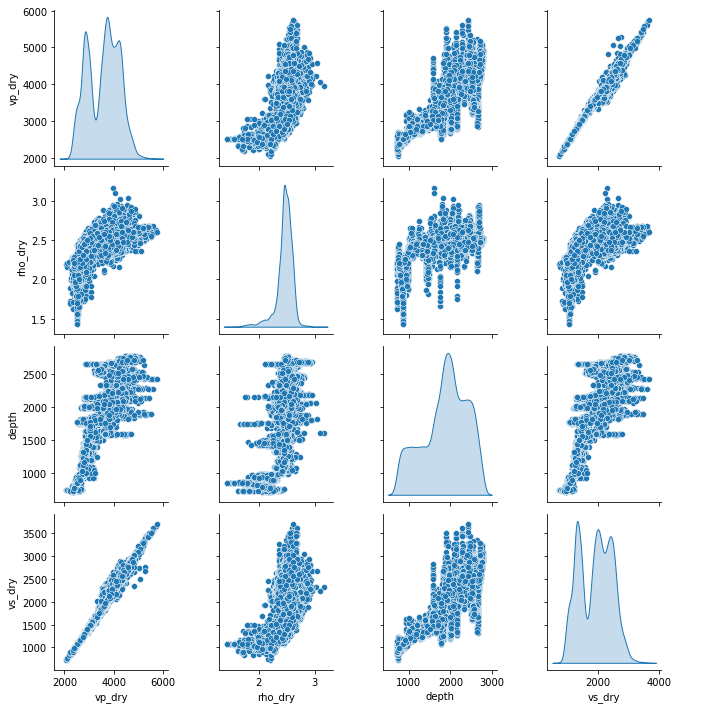

In [6]:
sns.pairplot(train_dataset[['vp_dry', 'rho_dry', 'depth', 'vs_dry']], diag_kind='kde')

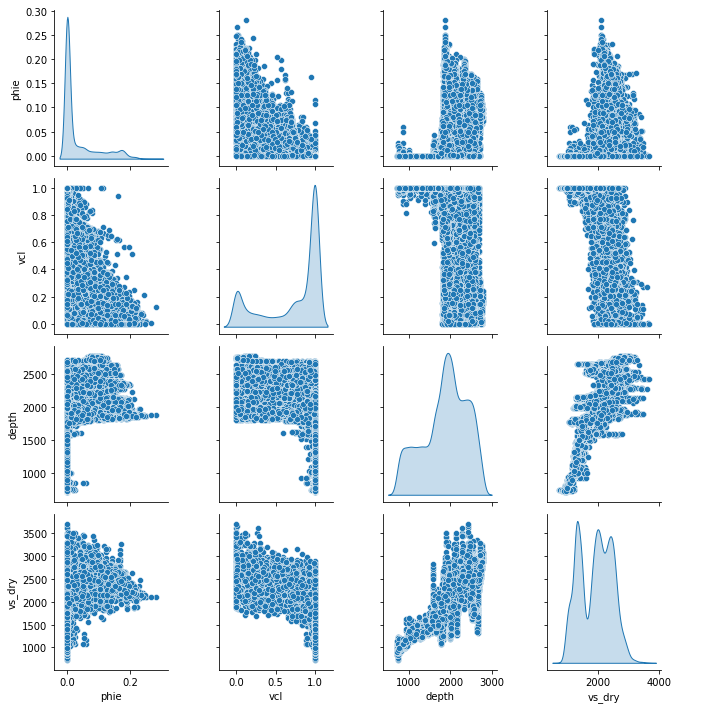

In [7]:
sns.pairplot(train_dataset[['phie', 'vcl', 'depth', 'vs_dry']], diag_kind='kde')

In [8]:
#train_dataset.describe().transpose()

### Split features from labels
We like to train the model to predict *vs_dry*, so we need to separate the target value, *vs_dry*, from the features (*input*). 

In [9]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('vs_dry')
test_labels = test_features.pop('vs_dry')

### Normalization
First see how the data is distributed

In [10]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
vp_dry,3571.779060,633.695256
vcl,0.713525,0.368935
phie,0.034263,0.057179
depth,1874.884291,518.733404
vs_dry,1922.868346,526.646368
rho_dry,2.457260,0.151549


#### Normalization layer
Create a normalization layer that includes the preprocessing into the model

In [12]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[3571.779    0.714    0.034 1874.884    2.457]


In [13]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[2841.84    1.      0.   1262.47    2.52]]

Normalized: [[-1.15  0.78 -0.6  -1.18  0.38]]


## Linear regression

### One variable
Lets try predict *vs_dry* from *vp_dry*.

Start by extracting the *vp* feature, and create a normalization layer

In [14]:
vp = np.array(train_features['vp_dry'])
vp_normalizer = preprocessing.Normalization(input_shape=[1,])
vp_normalizer.adapt(vp)

Then build the sequential model, of two layers

In [15]:
vp_model = tf.keras.Sequential([vp_normalizer, layers.Dense(units=1)])
vp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Configure the training procedure, by specifying the loss and optimizer

In [16]:
vp_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

The train the model by executing the *fit* function

In [17]:
%%time
history = vp_model.fit(train_features['vp_dry'], train_labels, epochs=100, verbose=0, validation_split=0.2)

Wall time: 12.6 s


Visualize the training process

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,31.747190,32.368752,95
96,31.750830,32.382847,96
97,31.747391,32.369499,97
98,31.745043,32.368053,98
99,31.752520,32.370991,99


In [28]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 50])
  plt.xlabel('Epoch')
  plt.ylabel('Error [vs]')
  plt.legend()
  plt.grid(True)

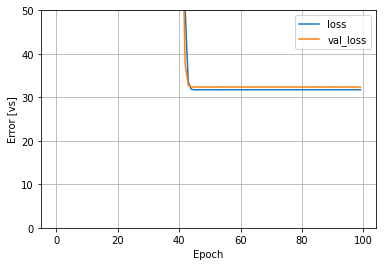

In [29]:
plot_loss(history)

In [23]:
x = tf.linspace(2000, 6000, 251)
y = vp_model.predict(x)

In [26]:
def plot_vp(x, y):
  plt.scatter(train_features['vp_dry'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('V_p')
  plt.ylabel('V_s')
  plt.legend()

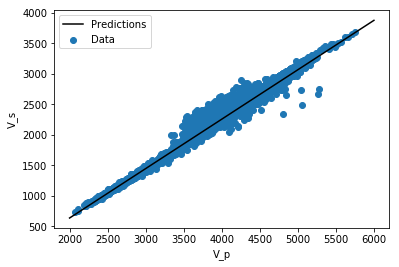

In [27]:
plot_vp(x,y)

In [36]:
test_results = {}
test_results['vp_model'] = vp_model.evaluate(test_features['vp_dry'], test_labels, verbose=0)

## DNN regression
These models will contain a few more layers than the linear model:
- The normalization layer.
- Two hidden, nonlinear, Dense layers using the relu nonlinearity.
- A linear single-output layer.

In [30]:
def build_and_compile_model(norm, units=64):
  model = keras.Sequential([
      norm,
      layers.Dense(units, activation='relu'),
      layers.Dense(units, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [32]:
dnn_model = build_and_compile_model(normalizer, 64)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


In [33]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 15.9 s


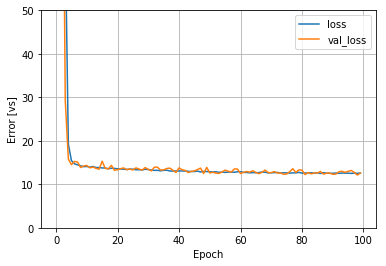

In [34]:
plot_loss(history)

In [38]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

In [43]:
pd.DataFrame(test_results, index=['Mean absolute error [vs_dry]']).T

,Mean absolute error [vs_dry]
vp_model,32.425388
dnn_model,12.432264


### Predictions

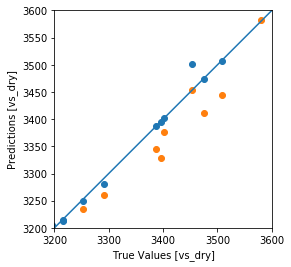

In [47]:
test_predictions_regression = vp_model.predict(test_features['vp_dry']).flatten()
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.scatter(test_labels, test_predictions_regression)
plt.xlabel('True Values [vs_dry]')
plt.ylabel('Predictions [vs_dry]')
lims = [ 3200, 3600]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [49]:
test_dict = {'A': {'Interval 1': 100, 'Interval 2': 200}, 'B': {'Interval 1': 300, 'Interval 2': 400}}
pd.DataFrame(test_dict).T

,Interval 1,Interval 2
A,100,200
B,300,400


In [13]:



dataset.iloc[22191]

vp_dry     4233.1225
rho_dry       2.3997
depth      2093.8112
phie          0.1652
vs_dry     2672.3025
vcl           0.0554
Well          2.0000
Name: 44991, dtype: float64

In [14]:
raw_dataset.loc[44991]

vp_dry     4233.1225
rho_dry       2.3997
depth      2093.8112
phie          0.1652
vs_dry     2672.3025
vcl           0.0554
Well          2.0000
Name: 44991, dtype: float64